In [ ]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import LineString, Point, Polygon

import matplotlib
norm = matplotlib.colors.Normalize()

%matplotlib inline

from shapely.geometry import box, Polygon

land = gpd.read_file('data/gshhs/f/GSHHS_f_L1.shp')

# SYRIA FIRST ITERATION

In [ ]:
path = 'cases/baniyas_medslik_v3/out_files/MDK_SIM_2021_08_23_1000_baniyas_medslik_v3/'
filename = path + 'spill_properties.nc'
ds = xr.open_dataset(filename)

lon_min,lon_max = 35.6,36
lat_min,lat_max = 35.1,35.8

rec = land.cx[lon_min:lon_max, lat_min:lat_max]

for t in range(0,72):
    dss = ds.isel(time=t)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_facecolor('#ADD8E6')
    rec.plot(ax=ax,color="#FFFDD0", edgecolor='black', zorder = 1000,aspect=1)
    ax.scatter(dss.longitude,dss.latitude,dss.non_evaporative_volume,color='r')
    
    plt.xlim(lon_min,lon_max)
    plt.ylim(lat_min,lat_max)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.title(f'time={t}')

    plt.grid()

    plt.savefig(f'{path}/figures/fig_test_{t:03d}.png',dpi=50)

Text(91.97222222222221, 0.5, 'Latitude')

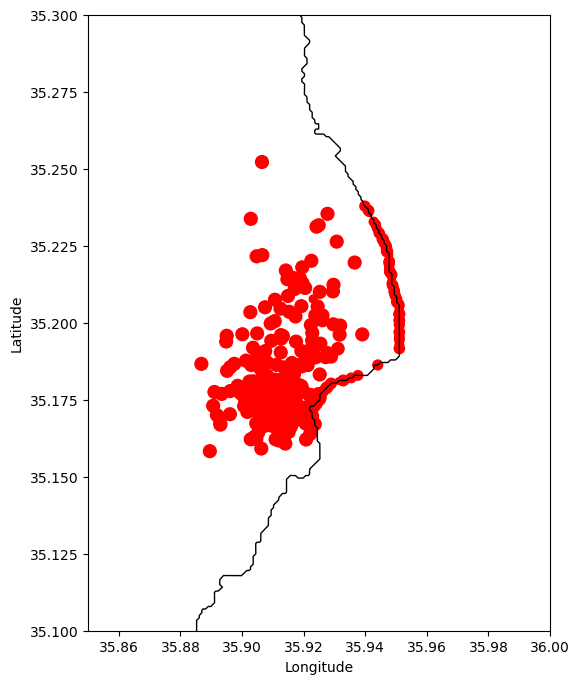

In [20]:
lon_min,lon_max = 35.85,36
lat_min,lat_max = 35.1,35.3

fig, ax = plt.subplots(figsize=(10, 8))
rec.plot(ax=ax,color="none", edgecolor='black', zorder = 1000,aspect=1)
ax.scatter(dss.longitude,dss.latitude,dss.non_evaporative_volume,color='r')

plt.xlim(lon_min,lon_max)
plt.ylim(lat_min,lat_max)

plt.xlabel('Longitude')
plt.ylabel('Latitude')


# Plotting Ascii files

## Bath Files

In [ ]:
def plot_bath(path):
    raw = pd.read_csv(path)
    #coordinates
    temp = raw.iloc[0,0].split(' ')
    coords = [float(value) if value else 0 for value in temp]
    coords = coords[:-1]

    lat_min, lat_max = coords[0],coords[1]
    lon_min, lon_max = coords[2],coords[3]

    #grid elements
    temp = raw.iloc[1,0].split(' ')
    elements = [int(value) if value else 0 for value in temp]
    elements[:-1]

    y_elem, x_elem = elements[0], elements[1]

    y = np.linspace(lat_min,lat_max,y_elem)
    x = np.linspace(lon_max,lon_min,x_elem)

    xx,yy = np.meshgrid(y,x)

    values = pd.read_csv(path,skiprows=2)

    #reshaped matrix
    reshaped = values.values.squeeze().reshape((x_elem,y_elem))

    dep = np.ma.masked_where(reshaped > 8000,reshaped)

    plt.figure()
    plt.pcolormesh(xx,yy,dep)
    plt.colorbar()


In [ ]:
plot_bath('cases/baniyas_medslik_v2/bnc_files/dtm.bath')

## Map files

In [ ]:
def plot_map(file_path):
    # Read the file, skipping lines ending with 0

    columns = ['Longitude', 'Latitude']
    df = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns,skiprows=1)

    df['label'] = np.NaN
    df['Latitude'] = df['Latitude'].replace(0, np.nan)

    # Initialize counter variable for labels
    label_counter = 1

    # Iterate through rows and update 'label' when 'Latitude' is NaN
    for index, row in df.iterrows():
        if pd.isna(row['Latitude']):
            df.at[index, 'label'] = label_counter
            label_counter += 1

    df['label'] = df.label.ffill()

    df = df.dropna()

    # df = df[(df.Longitude<lon_max)&(df.Longitude>lon_min)&(df.Latitude<lat_max)&(df.Latitude>lat_min)]

    # # Create a GeoDataFrame with LineString geometries
    geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

    gdf = gpd.GeoDataFrame(df,geometry=geometry)

    df_pol = gdf.groupby('label')['geometry'].apply(lambda x: LineString(x.tolist())).reset_index()

    # Declare the result as a new a GeoDataFrame
    gdf_pol = gpd.GeoDataFrame(df_pol, geometry = 'geometry')

    gdf_pol.plot()


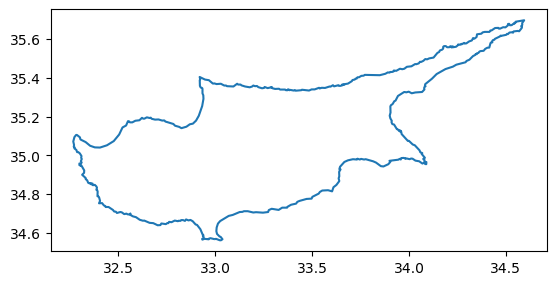

In [21]:
plot_map('cases/baniyas_medslik_v2/bnc_files/dtm.map')

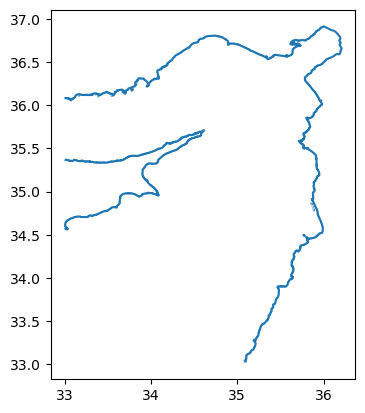

In [22]:
plot_map('cases/baniyas_medslik_v3/bnc_files/dtm.map')

## Mrc files

In [ ]:
# lon_min,lon_max = 14,20
# lat_min,lat_max = 38,42.5

# lon_min,lon_max = -45.6,-45.2
# lat_min,lat_max = -23.9,-23.5

lon_min,lon_max = -45.6,-45.2
lat_min,lat_max = -23.9,-23.5

rec = land.clip_by_rect(lon_min,lat_min,lon_max,lat_max)


def plot_mrc(file):

    df = pd.read_csv(file,skiprows=4, sep = '\s+')

    df = df[(df.lat>=lat_min-0.5)&(df.lat<=lat_max+0.5)&(df.lon>=lon_min-0.5)&(df.lon<=lon_max+0.5)]

    #Plotting Currents
    fig, ax = plt.subplots(figsize=(10, 8))
    rec.plot(ax=ax,color = 'none', edgecolor='black', zorder = 1000)

    magnitude = np.sqrt(df.u_srf**2 + df.v_srf**2)

    plt.quiver(df.lon,df.lat,df.u_srf,df.v_srf,magnitude,cmap='viridis',linewidth=magnitude)

    cbar = plt.colorbar(orientation='vertical')

    # Set the label for the colorbar
    cbar.set_label('Velocity (m/s)', rotation=270, labelpad=15)  # Use rotation to set the orientation

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.xlim(lon_min-0.2,lon_max+0.2)
    plt.ylim(lat_min-0.2,lat_max+0.2)

    #Plotting SST
    fig, ax = plt.subplots(figsize=(10, 8))
    rec.plot(ax=ax,color = 'none', edgecolor='black', zorder = 1000)
    
    plt.scatter(df.lon,df.lat,c = df.SST,cmap='viridis', vmin = 10)

    cbar = plt.colorbar(orientation='vertical')

    # Set the label for the colorbar
    cbar.set_label('SST (Celsius)', rotation=270, labelpad=15)  # Use rotation to set the orientation

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.xlim(lon_min-0.2,lon_max+0.2)
    plt.ylim(lat_min-0.2,lat_max+0.2)



In [ ]:
plot_mrc('cases/ilhabela_juno/oce_files/merc24012602.mrc')

## Met Files

In [ ]:
# lon_min,lon_max = 14,20
# lat_min,lat_max = 38,42.5

lon_min,lon_max = -45.6,-45.2
lat_min,lat_max = -23.9,-23.5

rec = land.clip_by_rect(lon_min,lat_min,lon_max,lat_max)


def plot_eri(filepath, hour):

    df = pd.read_csv(filepath,skiprows=5, sep = '\s+',header=None)

    #Plotting Currents

    hour = hour

    fig, ax = plt.subplots(figsize=(10, 8))
    rec.plot(ax=ax,color = 'none', edgecolor='black', zorder = 1000)

    magnitude = np.sqrt(df.iloc[:,3+hour]**2 + df.iloc[:,2+hour]**2)

    plt.quiver(df.iloc[:,1],df.iloc[:,0],df.iloc[:,2+2*hour],df.iloc[:,3+2*hour],magnitude,cmap='viridis',linewidth=2)

    cbar = plt.colorbar(orientation='vertical')

    # Set the label for the colorbar
    cbar.set_label('Velocity (m/s)', rotation=270, labelpad=15)  # Use rotation to set the orientation

    plt.title(f'{filepath.split("/")[-1]}_{hour}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')


In [ ]:
plot_eri('cases/taranto_witoil/witoil/OUT/MERCATOR_global_2023_11_23_1300_/MET/erai231124.eri',hour = 23)

In [ ]:
file = 'cases/taranto_juno2/met_files/erai231123.eri'

for hour in range(0,24):
    plot_eri('cases/taranto_juno2/met_files/erai231123.eri',hour = hour)
    plt.savefig(f'cases/taranto_juno2/met_files/figures/erai231123_{hour:02d}.png',dpi=100)
    plt.close()